In [1]:
PSEUDOCOUNT = 0.143
THRESHOLD = 0.2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('paper')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import warnings
import numpy as np
import pandas as pd

In [4]:
full_order = [
    'E. coli KFF-acpP',
    'E. coli (ΔsbmA) KFF-acpP',
    'E. coli D-KFF-acpP',
    'E. coli (UPEC) KFF-acpP',

    'E. coli KFF-rpsH',

    'K. pneumoniae KFF-acpP',
    'S. enterica KFF-acpP',

    'E. coli RXR-acpP',
    'P. aeruginosa RXR-acpP',
]

aso_order = ['KFF-rpsH', 'KFF-acpP',
             'D-KFF-acpP', 'RXR-acpP']

hue_order = ['E. coli', 'E. coli (ΔsbmA)',
             'E. coli (UPEC)',
             'K. pneumoniae',
             'S. enterica',
             'P. aeruginosa']

tab20 = sns.color_palette('tab20')
tab20c = sns.color_palette('tab20c')

palette = {'E. coli': tab20c[0],
           'E. coli (ΔsbmA)': tab20[6],
           'E. coli (UPEC)': tab20c[12],
           'K. pneumoniae': tab20c[4],
           'S. enterica': tab20c[8],
           'P. aeruginosa': tab20[12]}

In [5]:
def remove_zero(x):
    x['od'] = x['od600'] - x.loc[
                x.index.difference(x['strain'].dropna().index)
                    ]['od600'].mean()
    return x

def normalize(v, threshold=THRESHOLD, pseudocount=0.01):
    v = v.copy()
    
    # first time point is below the threshold
    # assume the strain was actual not there
    if v[v['log2(mic)'] == v['log2(mic)'].min()]['od'].mean() < threshold:
        v['x'] = np.nan
        v['y'] = np.nan
        
        return v

    x = v['log2(mic)'].values
    x = (x - x.min()) / (x.max() - x.min())
    y = v['od'].values
    y = (y - 0) / (0.8 - 0)
    v['x'] = x
    v['y'] = y
    
    # also log transform
    y = v['od'].values
    y = (y - 0) / (0.8 - 0)
    y[y <= pseudocount] = pseudocount
    y = np.log(y)
    y = (y - np.log(pseudocount)) / (np.log(0.8) - np.log(pseudocount))
    v['ln(y)'] = y
    
    return v

In [6]:
nv = pd.read_csv('../data/combined_aso_mic_mbc_20240502.csv', sep=',')

In [7]:
nv['species'] = ''
nv.loc[nv[nv['set'] == 'K'].index,
      'species'] = 'K. pneumoniae'
nv.loc[nv[nv['set'] == 'S'].index,
      'species'] = 'S. enterica'
nv.loc[nv[nv['set'] == 'U'].index,
      'species'] = 'E. coli (UPEC)'
nv.loc[nv[nv['set'] == 'A'].index,
      'species'] = 'E. coli'
nv.loc[nv[nv['set'] == 'J'].index,
      'species'] = 'E. coli (ΔsbmA)'
nv.loc[nv[nv['set'] == 'M'].index,
      'species'] = 'E. coli'
nv.loc[nv[nv['set'] == 'P'].index,
      'species'] = 'P. aeruginosa'
nv.loc[nv[nv['set'] == 'X'].index,
      'species'] = 'E. coli'
nv.loc[nv[nv['set'] == 'R'].index,
      'species'] = 'E. coli'
nv.loc[nv[nv['species'] == ''].index,
      'species'] = np.nan

nv['aso'] = ''
nv.loc[nv[nv['set'] == 'K'].index,
      'aso'] = 'KFF-acpP'
nv.loc[nv[nv['set'] == 'S'].index,
      'aso'] = 'KFF-acpP'
nv.loc[nv[nv['set'] == 'U'].index,
      'aso'] = 'KFF-acpP'
nv.loc[nv[nv['set'] == 'A'].index,
      'aso'] = 'D-KFF-acpP'
nv.loc[nv[nv['set'] == 'J'].index,
      'aso'] = 'KFF-acpP'
nv.loc[nv[nv['set'] == 'M'].index,
      'aso'] = 'KFF-acpP'
nv.loc[nv[nv['set'] == 'P'].index,
      'aso'] = 'RXR-acpP'
nv.loc[nv[nv['set'] == 'X'].index,
      'aso'] = 'RXR-acpP'
nv.loc[nv[nv['set'] == 'R'].index,
      'aso'] = 'KFF-rpsH'
nv.loc[nv[nv['aso'] == ''].index,
      'aso'] = np.nan

nv['name'] = [f'{x} {y}' if str(x) != 'nan'
              else np.nan
              for x, y in nv[['species', 'aso']].values]

In [8]:
order_set = nv.groupby('name')['set'].max().loc[full_order].values

/tmp/ipykernel_2151875/1365240761.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(full_order,


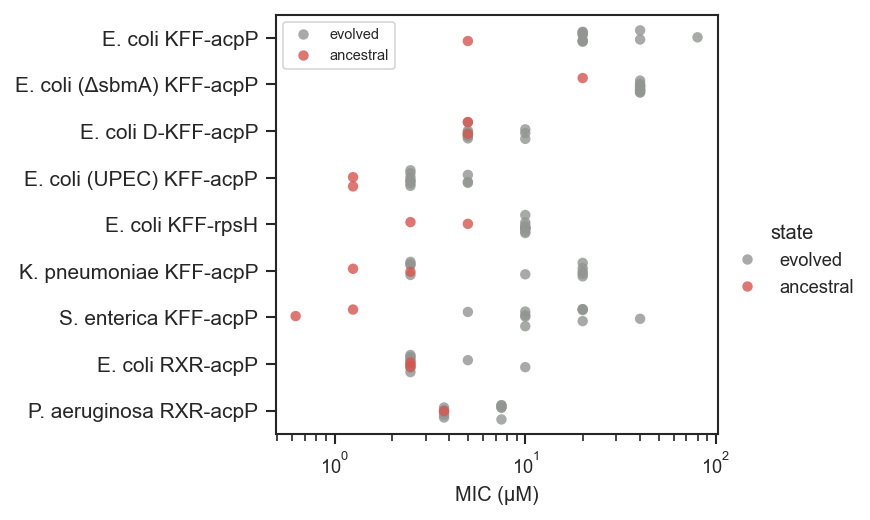

In [9]:
cp = sns.catplot(data=nv,
                 x='mic1',
                 y='set',
                 hue='state',
                 height=3.5, aspect=1.05,
                 jitter=0.2, alpha=0.8,
                 order=order_set,
                 palette=['xkcd:grey', 'xkcd:pale red'])

cp.set(xscale='log',
       xlabel='MIC (μM)',
       ylabel='')

plt.legend(facecolor='w', fontsize=7)

for ax in cp.axes.flatten():
    ax.set_yticklabels(full_order,
                       fontsize=10)

sns.despine(top=False, right=False)

plt.savefig('mics.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('mics.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/tmp/ipykernel_1950038/3273979937.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(full_order,


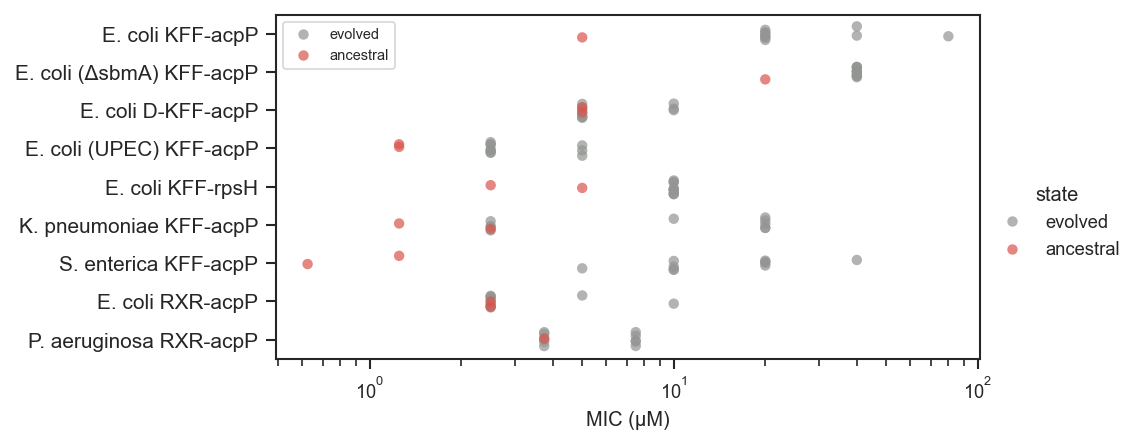

In [10]:
cp = sns.catplot(data=nv,
                 x='mic1',
                 y='set',
                 hue='state',
                 # kind='swarm',
                 height=3, aspect=1.8,
                 jitter=0.2, alpha=0.7,
                 order=order_set,
                 palette=['xkcd:grey', 'xkcd:pale red'])

cp.set(xscale='log',
       xlabel='MIC (μM)',
       ylabel='')

plt.legend(facecolor='w', fontsize=7)

for ax in cp.axes.flatten():
    ax.set_yticklabels(full_order,
                       fontsize=10)

sns.despine(top=False, right=False)

plt.savefig('mics_wide.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('mics_wide.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [11]:
res = []
for dset in ['A', 'K', 'R', 'S', 'U',
             'X', 'P']:
    v = nv[nv['set'] == dset]
    v1 = v[v['state'] == 'evolved']['mic1'] / v[(v['state'] == 'ancestral')
                                                # &
                                                # (v['source'] == 'own')
                                                ]['mic1'].mean()
    v1.index = [f'{dset}{i:02d}' for i in range(1, 11)]
    v1.name = 'rep1'
    v2 = v[v['state'] == 'evolved']['mic2'] / v[(v['state'] == 'ancestral')
                                                # &
                                                # (v['source'] == 'own')
                                                ]['mic1'].mean()
    v2.index = [f'{dset}{i:02d}' for i in range(1, 11)]
    v2.name = 'rep2'
    
    v = v1.to_frame().join(v2.to_frame())
    v['MIC'] = (v['rep1'] + v['rep2']) / 2

    res.append(v)
    
for dset in ['M', 'J']:
    v = nv[nv['set'] == dset]
    v1 = v[v['state'] == 'evolved']['mic1'] / v[(v['state'] == 'ancestral')
                                                # &
                                                # (v['source'] == 'own')
                                                ]['mic1'].mean()
    v1.index = [f'{dset}{i:02d}' for i in range(1, 11)]
    v1.name = 'rep1'
    
    v = v1.to_frame()
    v['rep2'] = np.nan
    v['MIC'] = v['rep1']

    res.append(v)

MIC = pd.concat(res)
fc = pd.Series(MIC['MIC'].to_dict()).to_frame().rename(columns={0: 'fold-change'})
fc['log2(fold-change)'] = np.log2(fc['fold-change'])

In [12]:
sorted(fc['log2(fold-change)'].unique())

[np.float64(0.0),
 np.float64(0.41503749927884376),
 np.float64(0.5849625007211562),
 np.float64(1.0),
 np.float64(1.4150374992788437),
 np.float64(1.584962500721156),
 np.float64(2.0),
 np.float64(2.415037499278844),
 np.float64(3.0),
 np.float64(3.415037499278844),
 np.float64(4.0),
 np.float64(4.415037499278844),
 np.float64(5.415037499278844)]

In [13]:
nv.index = [f'{x}{y:02d}'
            if z == 'evolved'
            else 'ancestral'
            for x, y, z in nv[['set', 'replicate', 'state']].values]

In [14]:
nfc = nv.join(fc, how='inner')

In [15]:
nfc['sample'] = [f'{x}{y:02d}' for x, y in nfc[['set', 'replicate']].values]

In [16]:
nfc.to_csv('fold_changes.tsv', sep='\t', index=False)

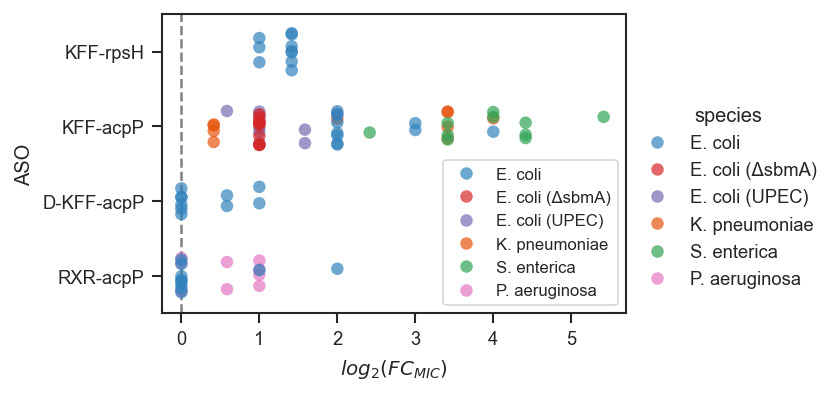

In [17]:
cp = sns.catplot(data=nfc,
                 x='log2(fold-change)',
                 y='aso',
                 hue='species',
                 height=2.7, aspect=1.7,
                 jitter=0.25,
                 order=aso_order,
                 hue_order=hue_order,
                 palette=[palette[x] for x in hue_order],
                 size=6,
                 alpha=0.7)

plt.legend(facecolor='w', fontsize=8)

cp.set(xlabel='$log_{2}(FC_{MIC})$', ylabel='ASO',
       xlim=(-0.25, 5.7))

for ax in cp.axes.flatten():
    ax.axvline(0, color='grey',
               ls='dashed', zorder=-1)

sns.despine(top=False, right=False)

plt.savefig('fold_change_mic.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('fold_change_mic.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

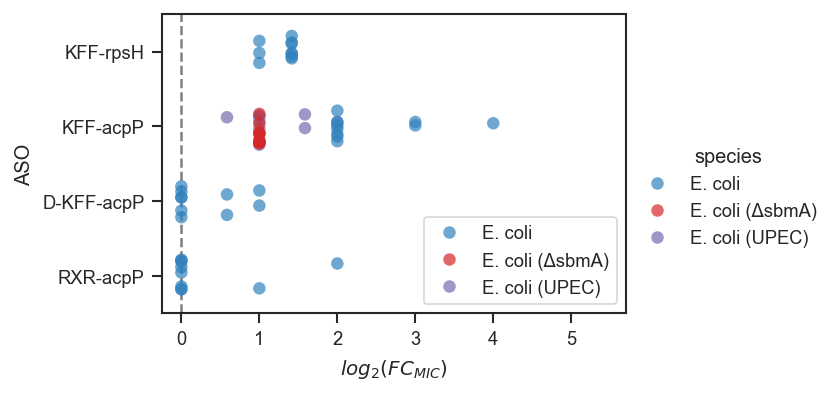

In [18]:
cp = sns.catplot(data=nfc[nfc['species'].str.startswith('E. coli')],
                 x='log2(fold-change)',
                 y='aso',
                 hue='species',
                 height=2.7, aspect=1.7,
                 jitter=0.25,
                 order=aso_order,
                 hue_order=hue_order[:3],
                 palette=[palette[x] for x in hue_order[:3]],
                 size=6,
                 alpha=0.7)

plt.legend(facecolor='w', loc='lower right')

cp.set(xlabel='$log_{2}(FC_{MIC})$', ylabel='ASO',
       xlim=(-0.25, 5.7))

for ax in cp.axes.flatten():
    ax.axvline(0, color='grey',
               ls='dashed', zorder=-1)

sns.despine(top=False, right=False)

plt.savefig('fold_change_mic_coli.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('fold_change_mic_coli.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

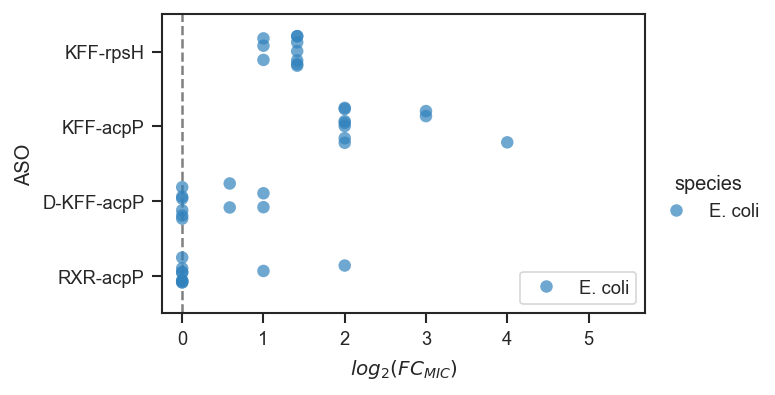

In [19]:
cp = sns.catplot(data=nfc[nfc['species'] == 'E. coli'],
                 x='log2(fold-change)',
                 y='aso',
                 hue='species',
                 height=2.7, aspect=1.7,
                 jitter=0.25,
                 order=aso_order,
                 hue_order=hue_order[:1],
                 palette=[palette[x] for x in hue_order[:1]],
                 size=6,
                 alpha=0.7)

plt.legend(facecolor='w', loc='lower right')

cp.set(xlabel='$log_{2}(FC_{MIC})$', ylabel='ASO',
       xlim=(-0.25, 5.7))

for ax in cp.axes.flatten():
    ax.axvline(0, color='grey',
               ls='dashed', zorder=-1)

sns.despine(top=False, right=False)

plt.savefig('fold_change_mic_coli_k12.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('fold_change_mic_coli_k12.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [20]:
# vmin = sorted(fc[fc['log2(fold-change)'] > 0]['log2(fold-change)'].unique())[0]
vmin = -0
vmax = 4

In [21]:
cmap = sns.color_palette('coolwarm',
                         as_cmap=True)
cmap.set_under('xkcd:grey')
cmap.set_over('#541b26ff')

In [22]:
fc.loc['X05']

fold-change          4.0
log2(fold-change)    2.0
Name: X05, dtype: float64

In [23]:
fc.loc['X08']

fold-change          2.0
log2(fold-change)    1.0
Name: X08, dtype: float64

In [24]:
fc.loc['X01']

fold-change          1.0
log2(fold-change)    0.0
Name: X01, dtype: float64

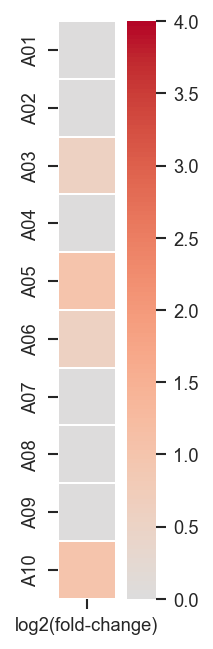

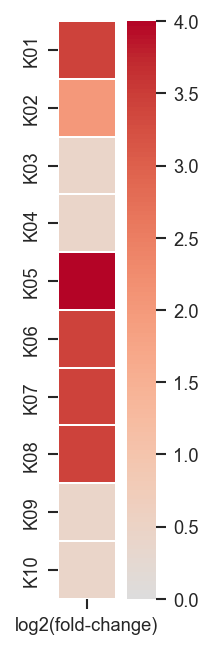

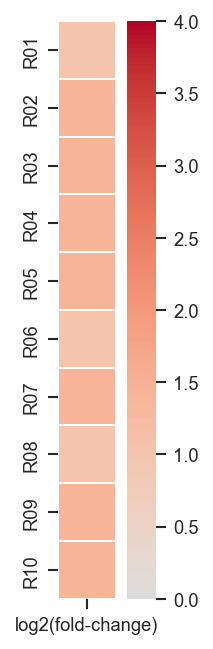

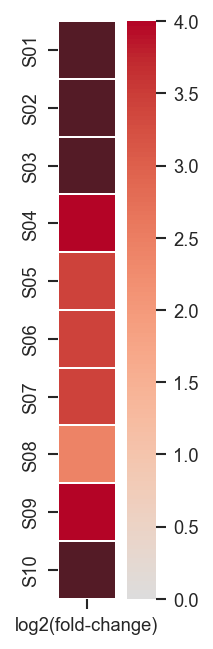

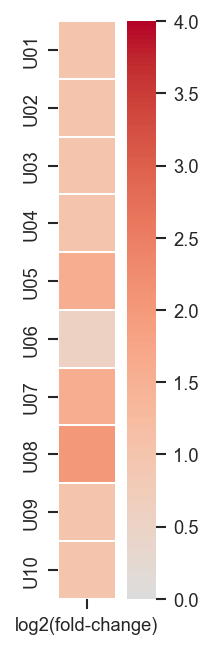

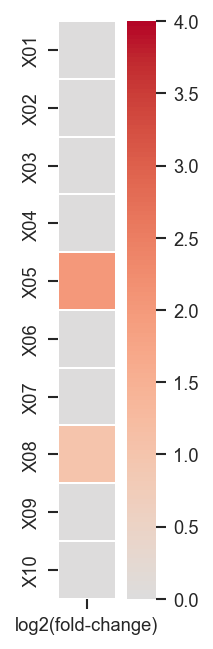

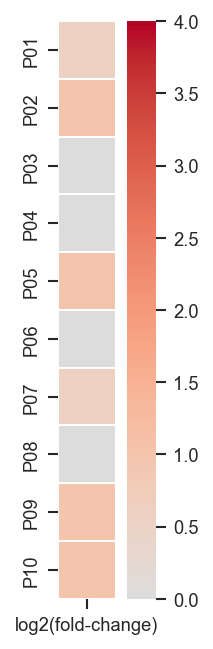

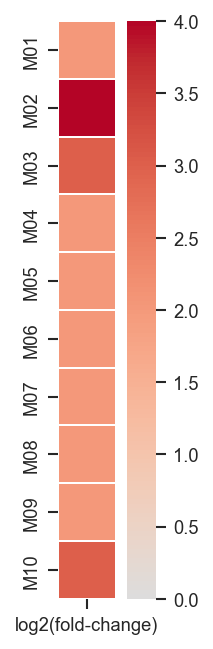

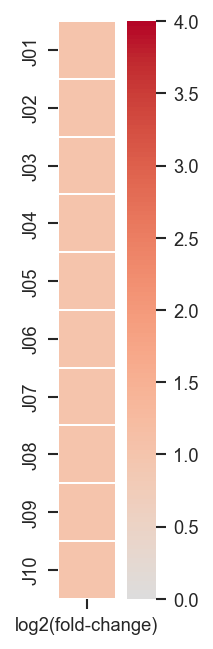

In [25]:
for dset in ['A', 'K', 'R', 'S', 'U',
             'X', 'P', 'M', 'J']:
    plt.figure(figsize=(2, 5))
    sns.heatmap(fc.loc[sorted([x for x in fc.index
                               if x.startswith(dset)]),
                       ['log2(fold-change)']],
                cmap=cmap, vmin=vmin, vmax=vmax,
                center=0,
                linewidths=0.1,
                square=True)
    
    plt.xlabel('')
    
    # plt.savefig(f'fc_{dset}_20240410.svg',
    #             dpi=300, bbox_inches='tight',
    #             transparent=True);

In [26]:
d_mic = {x: y for x, y in zip(list(range(1, 5)) + list(range(5, 9)) +
                              list(range(9, 13)) + list(range(13, 17)),
                              [0.5] * 4 + [1] * 4 + [2] * 4 + [4] * 4)}

In [27]:
res = []

m = pd.read_csv(f'../data/output_20221020.tsv.gz', sep='\t')
m['batch'] = '20221020'

m['mic'] = [d_mic[x] for x in m['passage'].values]

m['sample'] = ''
m['sample'] = [x[0] if str(x) != 'nan'
               else np.nan
               for x in m['strain'].values]
m.loc[m[m['sample'] == ''].index,
      'sample'] = np.nan

col = m.columns
m = m[col]
res.append(m)

m = pd.read_csv(f'../data/output_20231219.tsv.gz', sep='\t')
m['batch'] = '20231219'

def last_time_point(values):
    max_time = values['time'].max()
    return values[values['time'] == max_time]

m = m.groupby(['passage', 'row', 'column']).apply(last_time_point,
                                                  include_groups=False).reset_index().drop(columns='level_3')
m['replicate'] = 1
m['passage'] = [int(x[1:]) for x in m['passage'].values]
m['mic'] = [d_mic[x] for x in m['passage'].values]

m['sample'] = ''
m.loc[m[(m['strain'] == 'k12') &
        (m['treatment'] == 'acppd')].index,
      'sample'] = 'A'
m.loc[m[(m['strain'] == 'k12') &
        (m['treatment'] == 'rpsh')].index,
      'sample'] = 'R'
m.loc[m[(m['strain'] == 'k12') &
        (m['treatment'] == 'rxracpp')].index,
      'sample'] = np.nan
m.loc[m[(m['strain'] == 'klebsiella') &
        (m['treatment'] == 'acpp')].index,
      'sample'] = 'K'
m.loc[m[(m['strain'] == 'pseudomonas') &
        (m['treatment'] == 'rxracpp')].index,
      'sample'] = np.nan
m.loc[m[(m['strain'] == 'salmonella') &
        (m['treatment'] == 'acpp')].index,
      'sample'] = 'S'
m.loc[m[(m['strain'] == 'upec') &
        (m['treatment'] == 'acpp')].index,
      'sample'] = 'U'
m.loc[m[(m['column'] == 1) |
        (m['column'] == 12)].index,
      'treatment'] = np.nan
m.loc[m[m['sample'] == ''].index,
      'sample'] = np.nan

m = m[col]
res.append(m)

m = pd.read_csv(f'../data/output_20240409.tsv.gz', sep='\t')
m['batch'] = '20240409'

m['mic'] = [d_mic[x] for x in m['passage'].values]
m['sample'] = ''
m.loc[m[m['strain'] == 'pao1'].index,
      'sample'] = 'P'
m.loc[m[m['strain'] == 'mg1655'].index,
      'sample'] = 'X'
m.loc[m[m['sample'] == ''].index,
      'sample'] = np.nan

m = m[col]
res.append(m)

m = pd.concat(res)
m = m.reset_index(drop=True)

m['species'] = ''
m.loc[m[m['sample'] == 'K'].index,
      'species'] = 'K. pneumoniae'
m.loc[m[m['sample'] == 'S'].index,
      'species'] = 'S. enterica'
m.loc[m[m['sample'] == 'U'].index,
      'species'] = 'E. coli (UPEC)'
m.loc[m[m['sample'] == 'A'].index,
      'species'] = 'E. coli'
m.loc[m[m['sample'] == 'J'].index,
      'species'] = 'E. coli (ΔsbmA)'
m.loc[m[m['sample'] == 'M'].index,
      'species'] = 'E. coli'
m.loc[m[m['sample'] == 'P'].index,
      'species'] = 'P. aeruginosa'
m.loc[m[m['sample'] == 'X'].index,
      'species'] = 'E. coli'
m.loc[m[m['sample'] == 'R'].index,
      'species'] = 'E. coli'
m.loc[m[m['species'] == ''].index,
      'species'] = np.nan

m['aso'] = ''
m.loc[m[m['sample'] == 'K'].index,
      'aso'] = 'KFF-acpP'
m.loc[m[m['sample'] == 'S'].index,
      'aso'] = 'KFF-acpP'
m.loc[m[m['sample'] == 'U'].index,
      'aso'] = 'KFF-acpP'
m.loc[m[m['sample'] == 'A'].index,
      'aso'] = 'D-KFF-acpP'
m.loc[m[m['sample'] == 'J'].index,
      'aso'] = 'KFF-acpP'
m.loc[m[m['sample'] == 'M'].index,
      'aso'] = 'KFF-acpP'
m.loc[m[m['sample'] == 'P'].index,
      'aso'] = 'RXR-acpP'
m.loc[m[m['sample'] == 'X'].index,
      'aso'] = 'RXR-acpP'
m.loc[m[m['sample'] == 'R'].index,
      'aso'] = 'KFF-rpsH'
m.loc[m[m['aso'] == ''].index,
      'aso'] = np.nan

m['log2(mic)'] = np.log2(m['mic'])

m = m.groupby(['treatment', 'passage']).apply(remove_zero,
                                              include_groups=False).reset_index()
# m = m.groupby(['treatment', 'sample', 'row', 'column', 'replicate']).apply(normalize)

In [28]:
lines = [(i + 1)
         for i in range(16)
         if (i + 1) % 4 == 0]

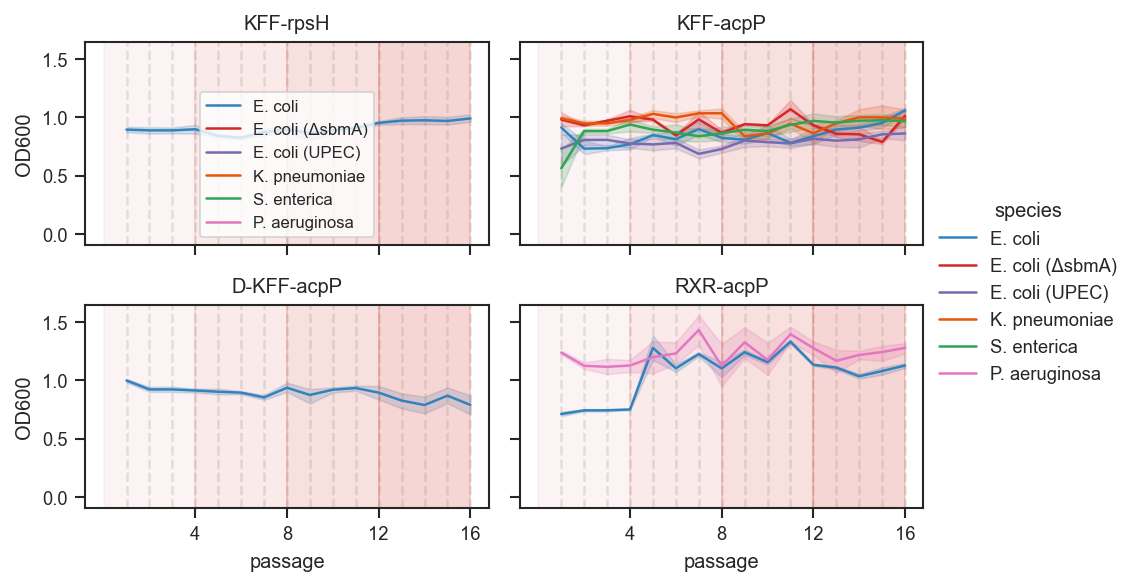

In [29]:
rp = sns.relplot(data=m,
                 x='passage', y='od600',
                 kind='line',
                 hue='species',
                 hue_order=hue_order,
                 palette=[palette[x] for x in hue_order],
                 col='aso', col_wrap=2,
                 col_order=aso_order,
                 height=2, aspect=1.6)

rp.axes.flatten()[0].legend(facecolor='w', fontsize=8)

rp.set_titles('{col_name}');
rp.set(ylabel='OD600',
       xlabel='passage',
       xticks=(lines),
       ylim=(-0.1, 1.65),
       )
for ax in rp.axes.flatten():
    for i in range(1, 17):
        ax.axvline(i, color='xkcd:light grey',
                   alpha=0.7,
                   ls='dashed',
                   zorder=-1)
    for i, v in enumerate(lines):
        ax.fill_between([v - 4, v],
                        [-1, -1],
                        [1.8, 1.8],
                        color='xkcd:pale red', alpha=0.06 * (i + 1))

sns.despine(top=False, right=False)

plt.savefig('od_readings.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('od_readings.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

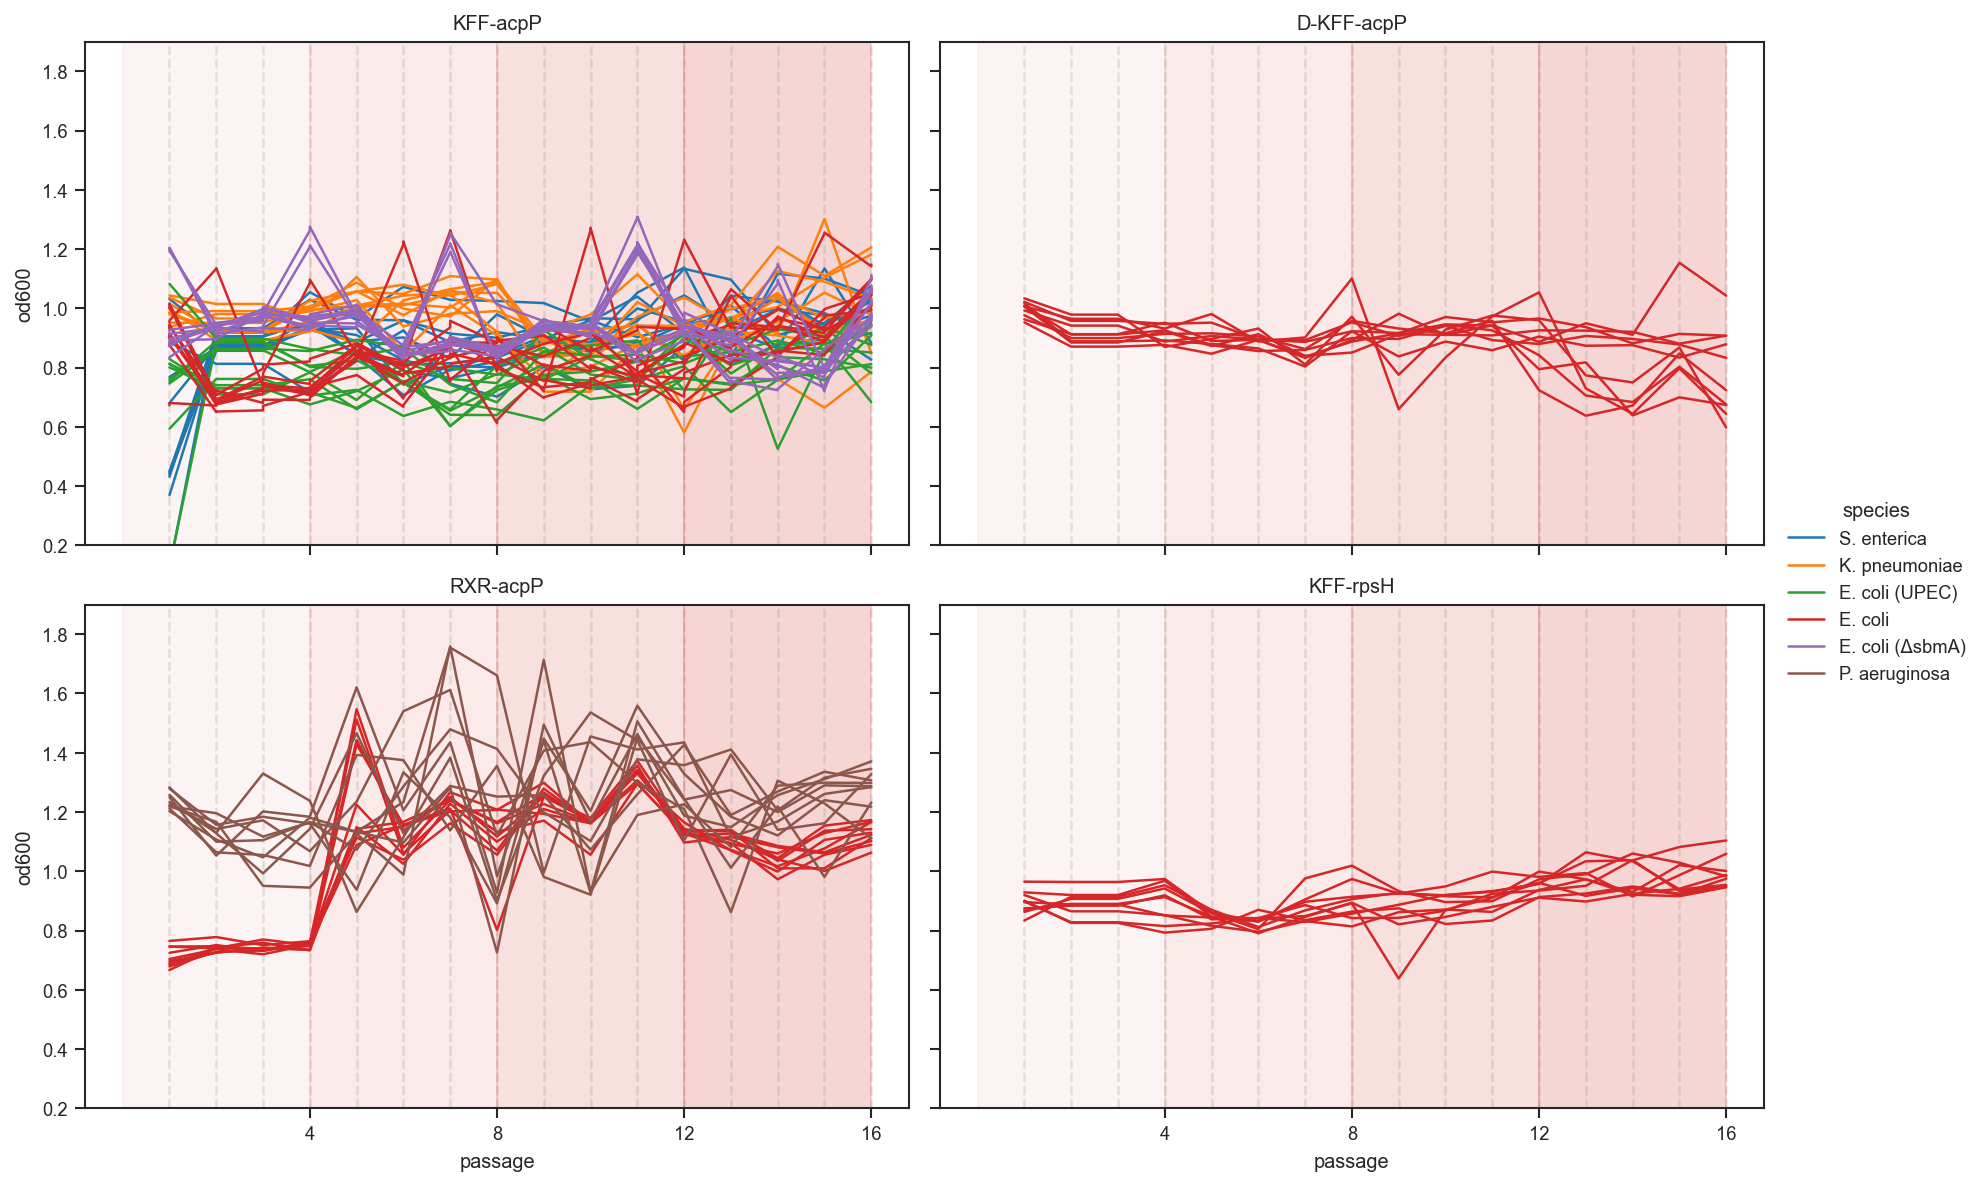

In [30]:
rp = sns.relplot(data=m,
                 x='passage', y='od600',
                 kind='line',
                 hue='species',
                 estimator=None,
                 units='column',
                 palette='tab10',
                 col='aso', col_wrap=2,
                 height=4, aspect=1.5)

rp.set_titles('{col_name}');
rp.set(ylabel='od600',
       xticks=(lines),
       ylim=(0.2, 1.9),
       )
for ax in rp.axes.flatten():
    for i in range(1, 17):
        ax.axvline(i, color='xkcd:light grey',
                   alpha=0.7,
                   ls='dashed',
                   zorder=-1)
    for i, v in enumerate(lines):
        ax.fill_between([v - 4, v],
                        [0, 0],
                        [2, 2],
                        color='xkcd:pale red', alpha=0.06 * (i + 1))

sns.despine(top=False, right=False);

In [31]:
m['full name'] = [f'{y} {x}' for x, y in m[['aso',
                                            'species']].values]

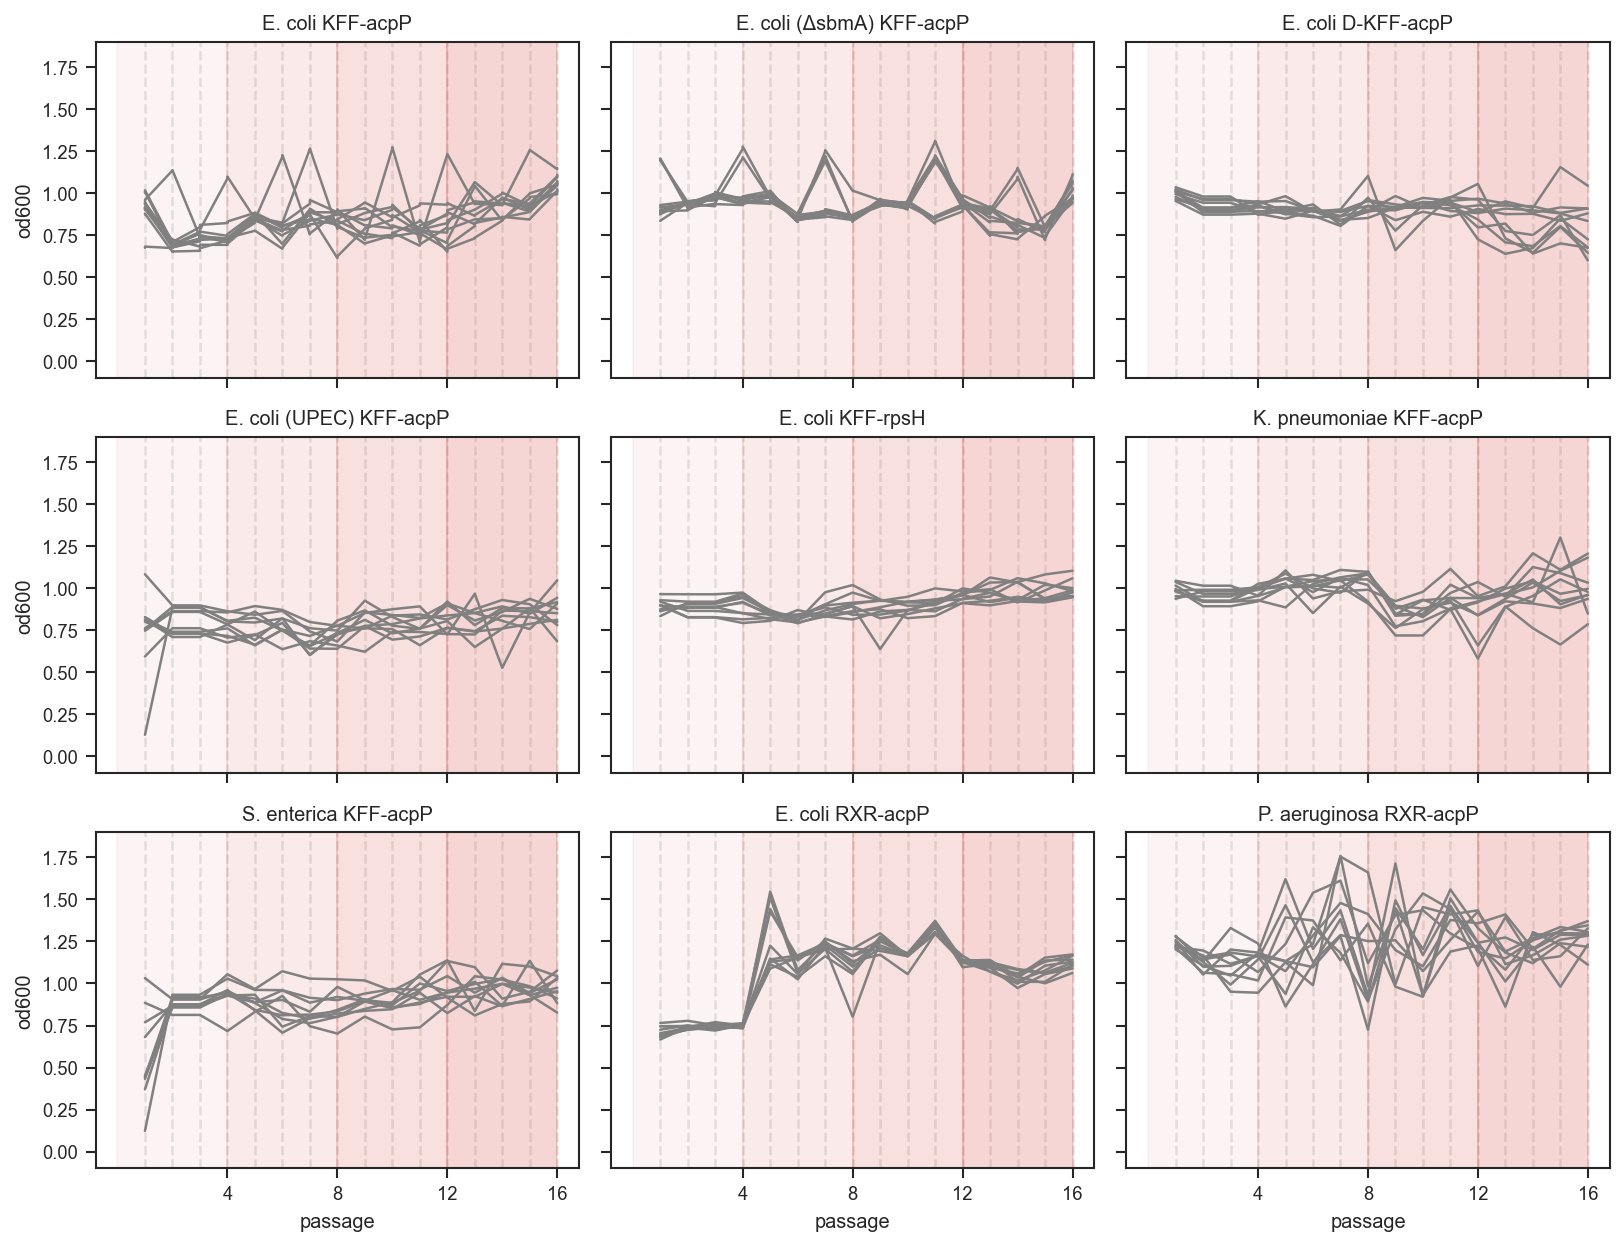

In [32]:
rp = sns.relplot(data=m[m['full name'] != 'nan nan'],
                 x='passage', y='od600',
                 kind='line',
                 # hue='aso',
                 estimator=None,
                 units='column',
                 color='grey',
                 col='full name', col_wrap=3,
                 height=2.8, aspect=1.3,
                 col_order=full_order)

rp.set_titles('{col_name}');
rp.set(ylabel='od600',
       xticks=(lines),
       ylim=(-0.1, 1.9),
       )
for ax in rp.axes.flatten():
    for i in range(1, 17):
        ax.axvline(i, color='xkcd:light grey',
                   alpha=0.7,
                   ls='dashed',
                   zorder=-1)
    for i, v in enumerate(lines):
        ax.fill_between([v - 4, v],
                        [-1, -1],
                        [2, 2],
                        color='xkcd:pale red', alpha=0.06 * (i + 1))

sns.despine(top=False, right=False)

plt.savefig('od_readings_full.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('od_readings_full.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

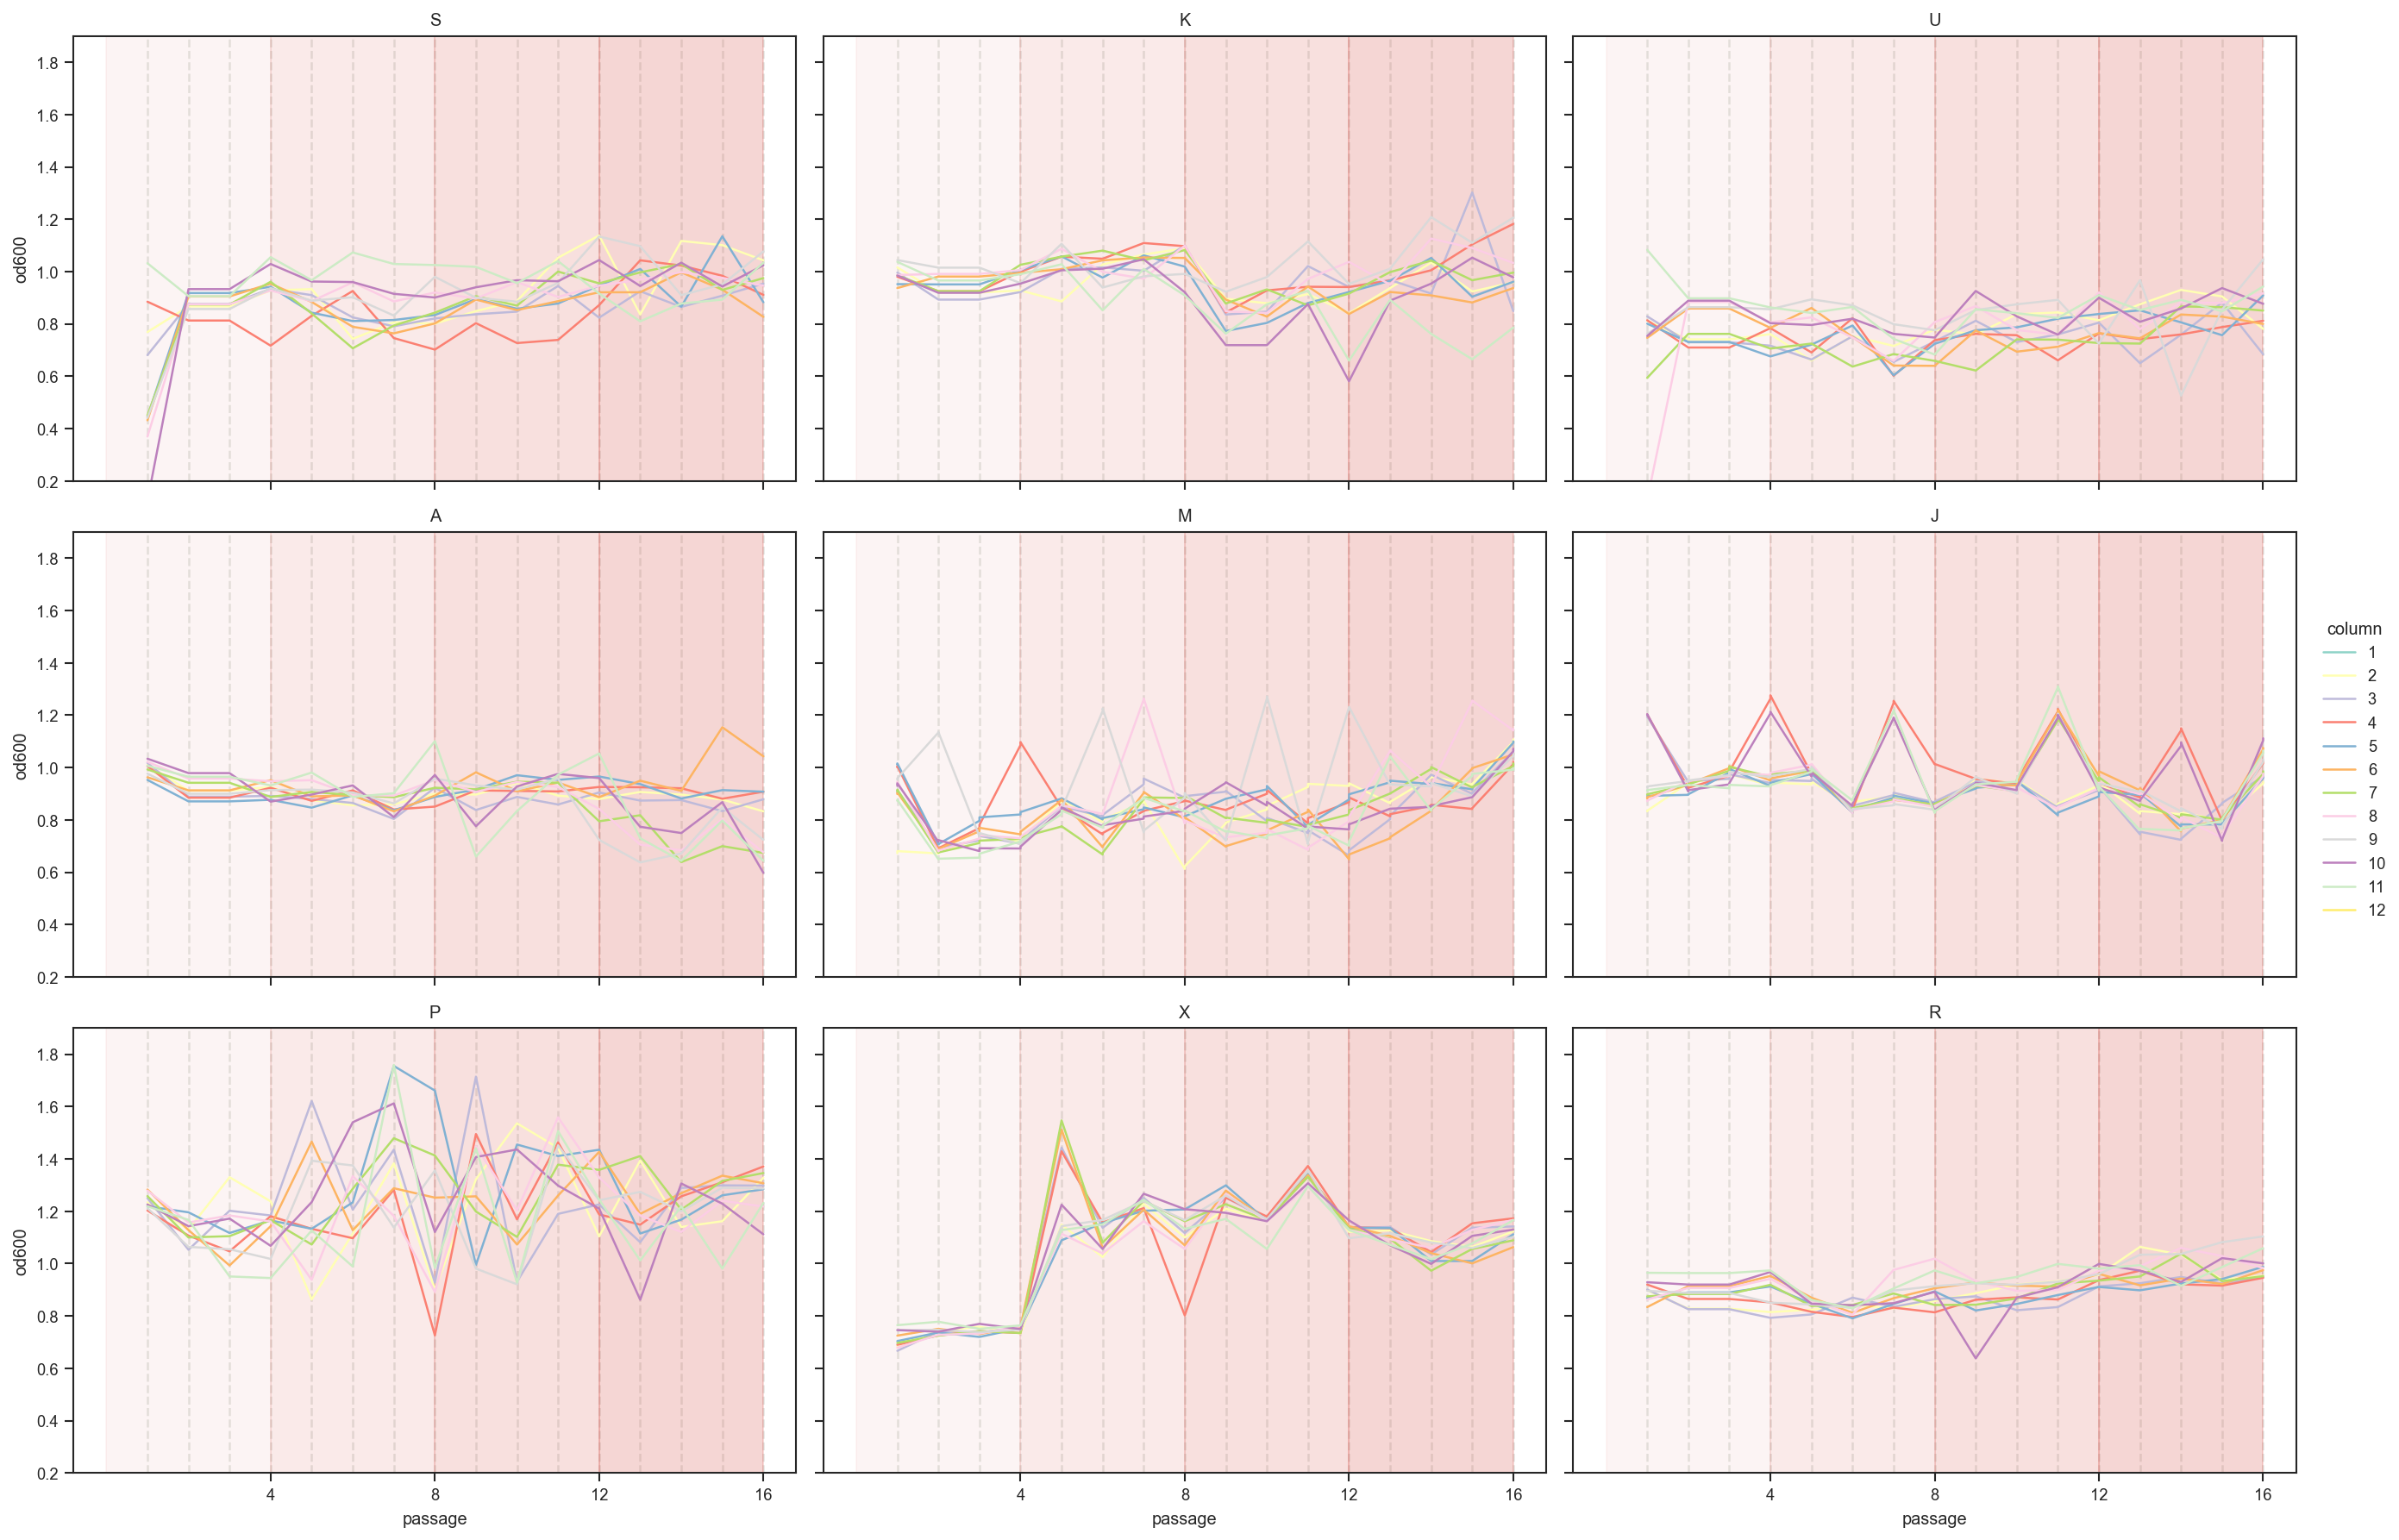

In [33]:
rp = sns.relplot(data=m,
                 x='passage', y='od600',
                 kind='line',
                 hue='column',
                 estimator=None,
                 units='column',
                 palette='Set3',
                 col='sample', col_wrap=3,
                 height=4, aspect=1.5)

rp.set_titles('{col_name}');
rp.set(ylabel='od600',
       xticks=(lines),
       ylim=(0.2, 1.9),
       )
for ax in rp.axes.flatten():
    for i in range(1, 17):
        ax.axvline(i, color='xkcd:light grey',
                   alpha=0.7,
                   ls='dashed',
                   zorder=-1)
    for i, v in enumerate(lines):
        ax.fill_between([v - 4, v],
                        [0, 0],
                        [2, 2],
                        color='xkcd:pale red', alpha=0.06 * (i + 1))

sns.despine(top=False, right=False);